## Load Modules/Libraries

In [1]:
import sys

In [2]:
sys.path.insert(0, '/Users/joshua/Developer/civetqc')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from scipy.stats.distributions import loguniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [5]:
from civetqc.data import Dataset
from civetqc.model import Model

## Load Dataset

In [6]:
TRAINING_DATASET_PATH = "/Users/joshua/Developer/civetqc/data/processed/training_dataset.csv"

In [7]:
training_data = Dataset.from_csv(TRAINING_DATASET_PATH)

## Training

In [8]:
np.random.seed(0)

In [9]:
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5)

In [10]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [11]:
param_distributions = {
    'n_estimators': np.arange(50, 501),
    'max_depth': np.arange(5, 51),
    'max_features': loguniform(0.01, 1.0),
    'min_samples_split': np.arange(2, 6),
    'min_samples_leaf': np.arange(1, 6),
}

In [12]:
search = RandomizedSearchCV(clf, param_distributions, cv=cv, scoring=f2_scorer)

In [13]:
search.fit(training_data.features, training_data.target)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'max_features': <scipy.stats._distn_infrastructure.rv_conti...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500])},
                   scoring=make_scorer(fbeta_score, beta=2))

In [14]:
best_estimator = search.best_estimator_

## Plot Discrimination Thresholds for Best Estimator

In [15]:
discrimination_thresholds = np.arange(0, 1.1, .1)

In [16]:
scores = {
    'Precision': [],
    'Recall': [],
    'F2': []
}

In [17]:
for threshold in discrimination_thresholds:
    probabilities = best_estimator.predict_proba(training_data.features)[:, 1]
    predictions = np.where(probabilities > threshold, 1, 0)
    scores['Precision'].append(precision_score(training_data.target, predictions, zero_division=1))
    scores['Recall'].append(recall_score(training_data.target, predictions))
    scores['F2'].append(fbeta_score(training_data.target, predictions, beta=2))

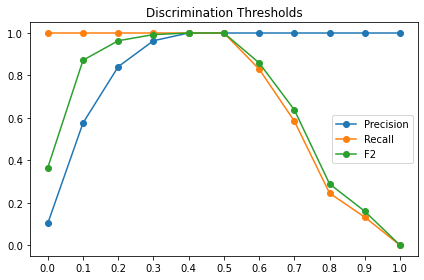

In [18]:
fig, ax = plt.subplots()
for key, value in scores.items():
    ax.plot(discrimination_thresholds, scores[key], label=key, marker='o')
ax.set_xticks(discrimination_thresholds)
ax.set_title("Discrimination Thresholds")
ax.legend()
fig.tight_layout()

## Save Model

In [19]:
model = Model(best_estimator, threshold=0.4)

In [20]:
model.save()